In [ ]:
"""
FULL PIPELINE (NO EXTREMES FILES):
1. Load original pollutant+meteorology file
2. Compute daily mean pollutant (“Mean” variable)
3. Rank days by daily mean
4. Select N highest and N lowest days
5. Compute meteorology composites for those days
6. Plot smooth composites using contourf
"""

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# ------------------------------
# USER INPUTS
# ------------------------------

pollutant_files = {
    'CO':    r"D:\IPMA\Results\co_fire_meteo_Iberia.nc",
    'NO':    r"D:\IPMA\Results\no_fire_meteo_Iberia.nc",
    'NO2':   r"D:\IPMA\Results\no2_fire_meteo_Iberia.nc",
    'PM2.5': r"D:\IPMA\Results\pm2p5_fire_meteo_Iberia.nc",
    'PM10':  r"D:\IPMA\Results\pm10_fire_meteo_Iberia.nc"
}

# Number of days to select for high & low extremes
N_days = 25

# Meteorological variables to composite
meteo_vars = {
    "precip_Total_Precipitation": ("m", "PuBu"),
    "temp_Max": ("°C", "coolwarm"),
    "wind_Max": ("m/s", "Oranges")
}

# Human-readable names
meteo_var_names = {
    "precip_Total_Precipitation": "Total Precipitation",
    "temp_Max": "Max Temperature",
    "wind_Max": "Max Wind Speed"
}

# ------------------------------
# PLOTTING FUNCTION (smooth version)
# ------------------------------

def plot_composites(pol, comp_max, comp_min):
    for var, (unit, cmap) in meteo_vars.items():

        if var not in comp_max:
            print(f"⚠ WARNING: {var} not found in dataset for {pol}. Skipped.")
            continue

        fig, axes = plt.subplots(
            1, 2,
            figsize=(9, 5),
            subplot_kw={'projection': ccrs.PlateCarree()},
            gridspec_kw={'wspace': 0.07}
        )

        titles = [
            f"{pol} High Composite – {meteo_var_names[var]}",
            f"{pol} Low Composite – {meteo_var_names[var]}"
        ]

        for ax, ds, title in zip(axes, [comp_max, comp_min], titles):

            data = ds[var]

            # Mask invalid points
            mask = np.isfinite(data)
            data_masked = data.where(mask)

            # Determine bounding box of valid data
            if mask.any():
                lat_vals = ds["latitude"].values
                lon_vals = ds["longitude"].values

                valid_idx = np.where(mask.values)
                lat_idx = valid_idx[0]
                lon_idx = valid_idx[1]

                lat_min = max(lat_vals[lat_idx].min() - (lat_vals[1]-lat_vals[0]), lat_vals.min())
                lat_max = min(lat_vals[lat_idx].max() + (lat_vals[1]-lat_vals[0]), lat_vals.max())
                lon_min = max(lon_vals[lon_idx].min() - (lon_vals[1]-lon_vals[0]), lon_vals.min())
                lon_max = min(lon_vals[lon_idx].max() + (lon_vals[1]-lon_vals[0]), lon_vals.max())
            else:
                lat_min, lat_max = ds["latitude"].min(), ds["latitude"].max()
                lon_min, lon_max = ds["longitude"].min(), ds["longitude"].max()

            # Smooth plot with contourf
            img = ax.contourf(
                ds["longitude"],
                ds["latitude"],
                data_masked,
                levels=20,
                cmap=cmap,
                extend="both",
                transform=ccrs.PlateCarree()
            )

            ax.set_title(title, fontsize=11)
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linewidth=0.8)

            # Set extent to only the area with real data
            ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # Horizontal colorbar
        cbar_ax = fig.add_axes([0.22, 0.06, 0.6, 0.03])
        cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(f"{unit}")

        plt.tight_layout(rect=[0, 0.12, 1, 1])
        plt.show()



# ------------------------------
# MAIN LOOP
# ------------------------------

for pol, file_path in pollutant_files.items():

    print("\n======================================================")
    print(f"🌫️ PROCESSING POLLUTANT: {pol}")
    print("======================================================")

    ds = xr.open_dataset(file_path)

    if "Mean" not in ds:
        print(f"❌ ERROR: 'Mean' not found in file {file_path}")
        continue

    # Convert CO units mg → µg (your original code)
    if pol == "CO":
        ds["Mean"] = ds["Mean"] * 1000.0

    # ----------------------------------------------------
    # 1. DAILY MEAN POLLUTANT VALUE
    # ----------------------------------------------------
    # Collapse spatial dims; keep time dimension only
    daily_mean = ds["Mean"].mean(dim=("latitude", "longitude"), skipna=True)

    # ----------------------------------------------------
    # 2. RANK DAYS
    # ----------------------------------------------------
    ds_sorted = daily_mean.sortby(daily_mean, ascending=False)

    high_days = ds_sorted.time.values[:N_days]
    low_days  = ds_sorted.time.values[-N_days:]

    print(f"📌 {pol}: Selected {len(high_days)} high days")
    print(f"📌 {pol}: Selected {len(low_days)} low days")

    # ----------------------------------------------------
    # 3. METEOROLOGY COMPOSITES
    # ----------------------------------------------------
    comp_max = ds.sel(time=high_days).mean(dim="time", skipna=True)
    comp_min = ds.sel(time=low_days).mean(dim="time", skipna=True)

    # ----------------------------------------------------
    # 4. PLOTTING
    # ----------------------------------------------------
    print(f"📍 Plotting composites for {pol} ...")
    plot_composites(pol, comp_max, comp_min)

    ds.close()

print("\n🎉 COMPLETED SUCCESSFULLY!")



🌫️ PROCESSING POLLUTANT: CO
📌 CO: Selected 30 high days
📌 CO: Selected 30 low days
📍 Plotting global mean meteo maps for CO ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


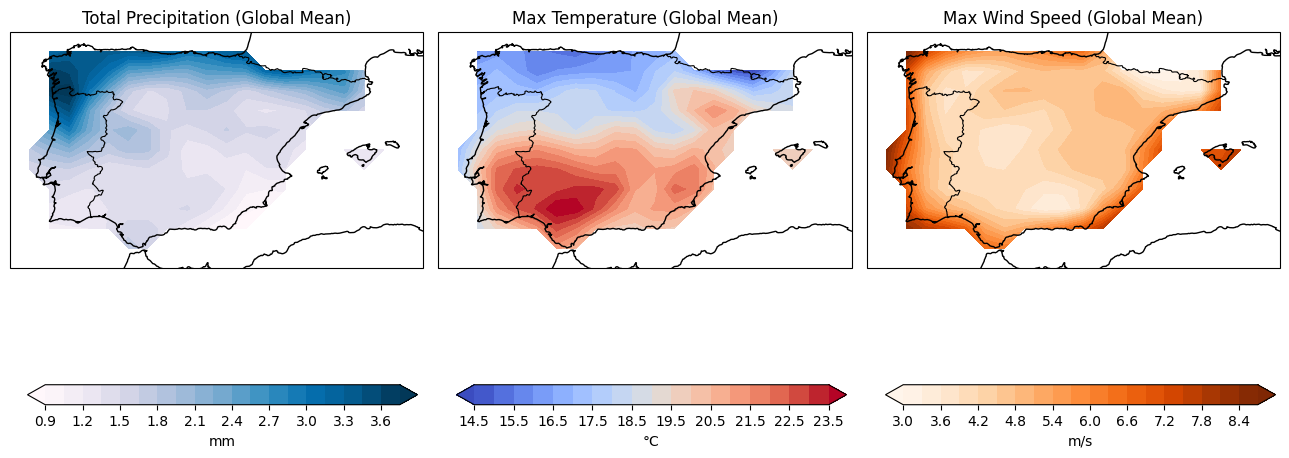

📍 Plotting original composites for CO ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


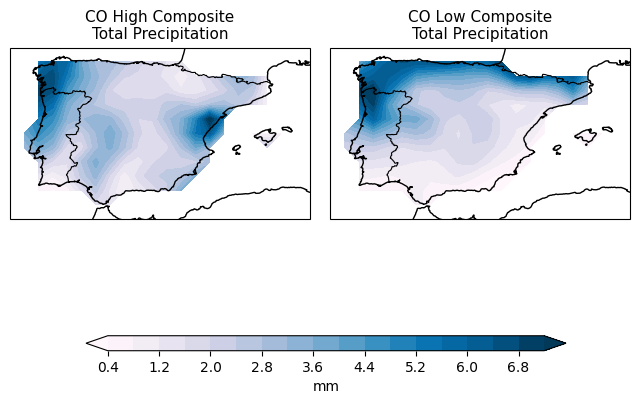

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


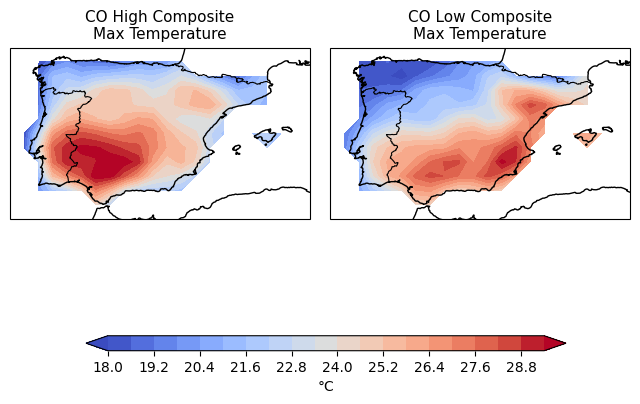

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


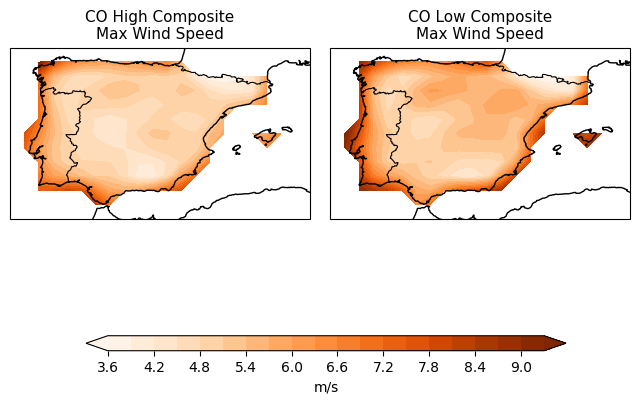

📍 Plotting anomaly composites for CO ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


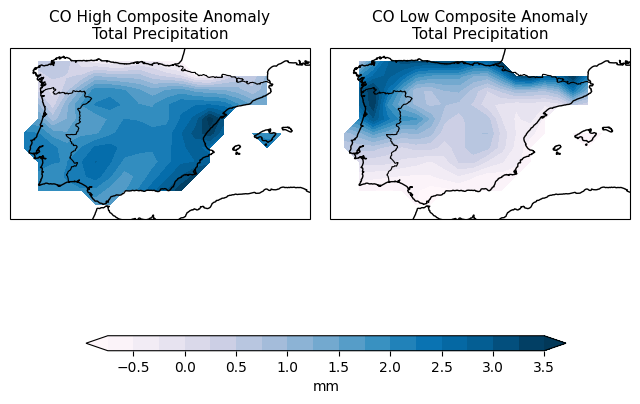

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


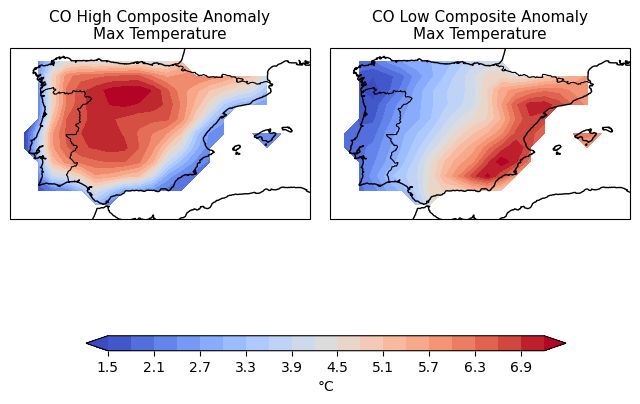

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


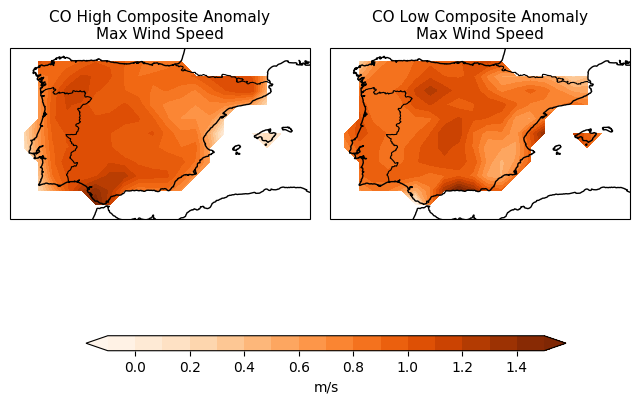


🌫️ PROCESSING POLLUTANT: NO
📌 NO: Selected 30 high days
📌 NO: Selected 30 low days
📍 Plotting global mean meteo maps for NO ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


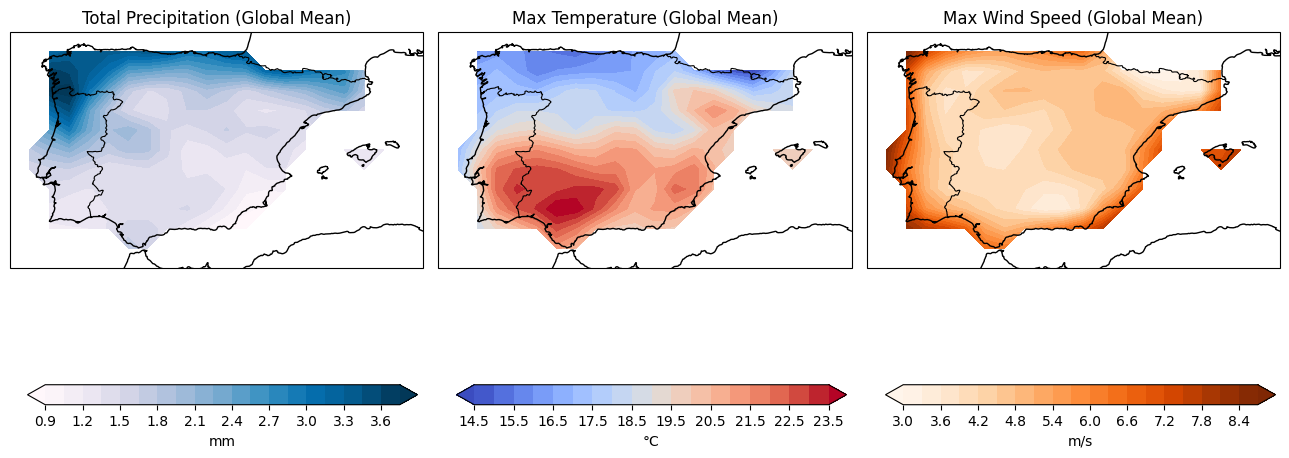

📍 Plotting original composites for NO ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


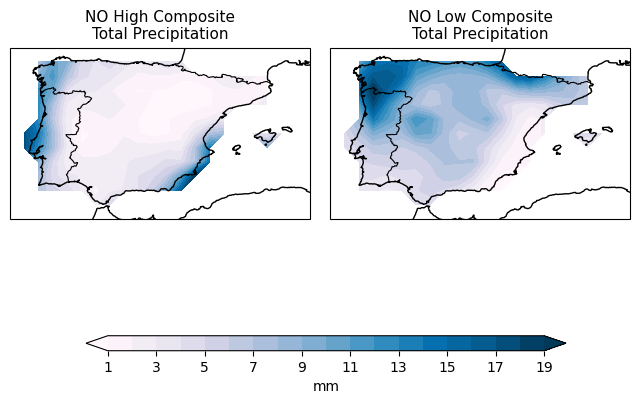

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


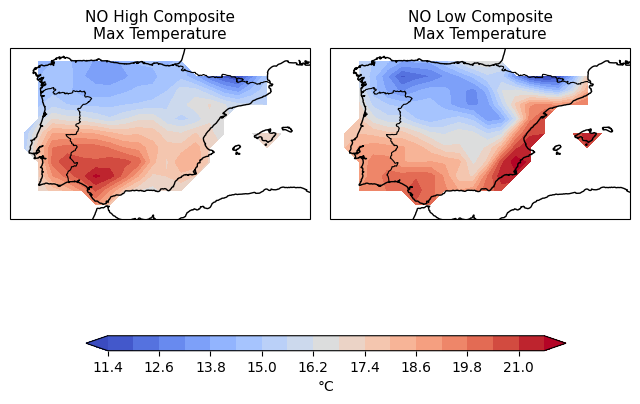

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


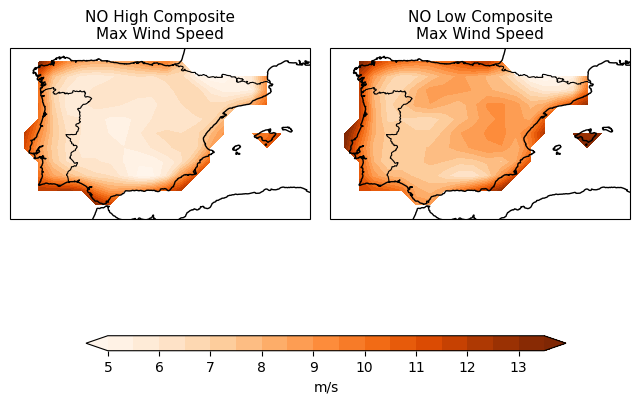

📍 Plotting anomaly composites for NO ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


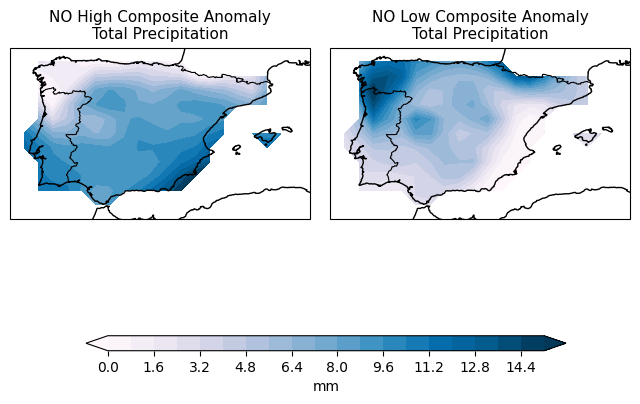

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


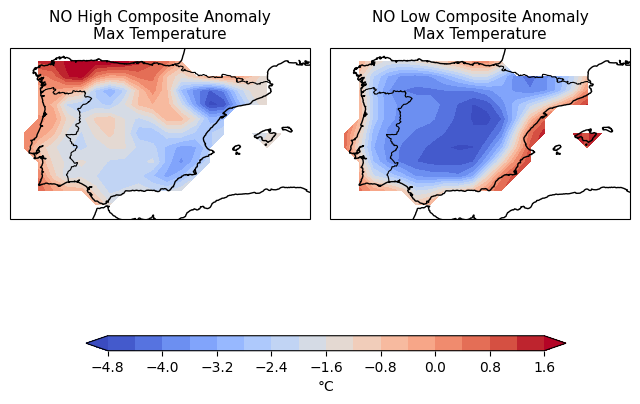

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


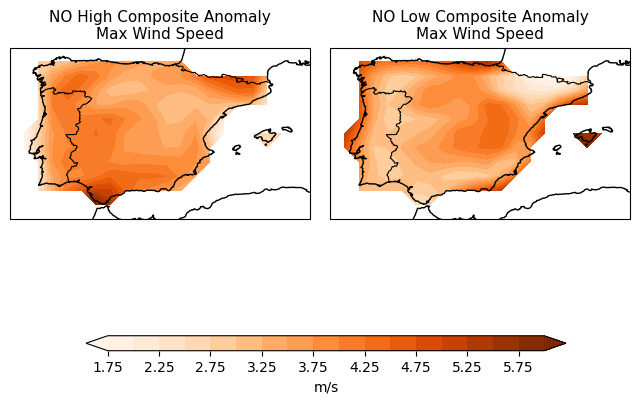


🌫️ PROCESSING POLLUTANT: NO2
📌 NO2: Selected 30 high days
📌 NO2: Selected 30 low days
📍 Plotting global mean meteo maps for NO2 ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


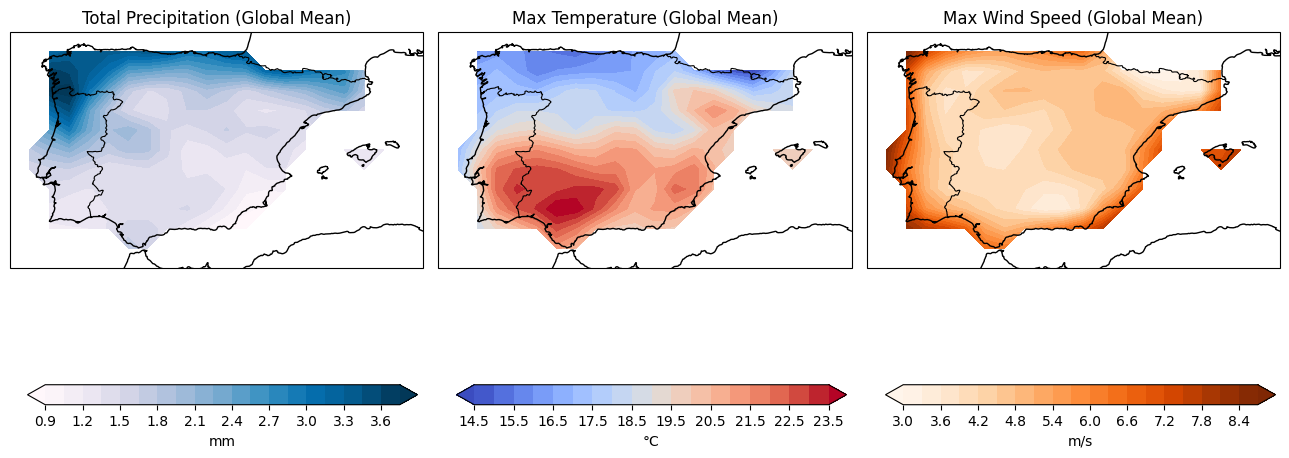

📍 Plotting original composites for NO2 ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


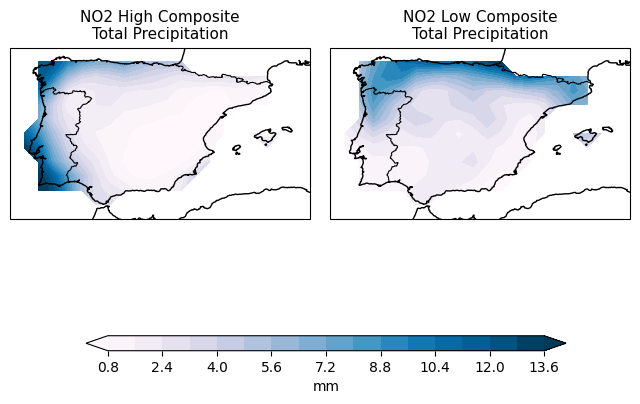

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


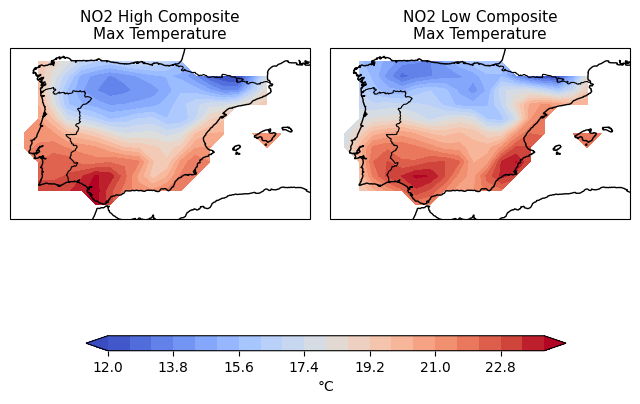

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


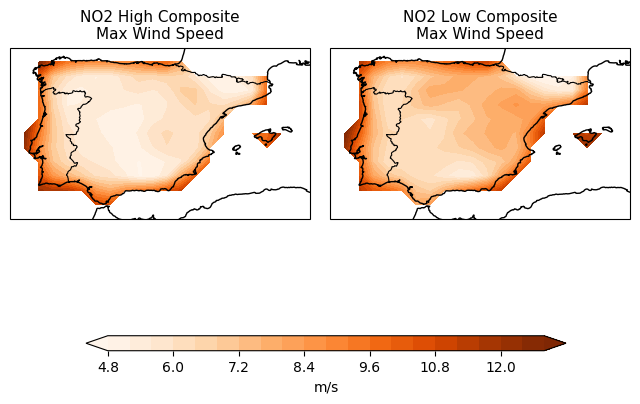

📍 Plotting anomaly composites for NO2 ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


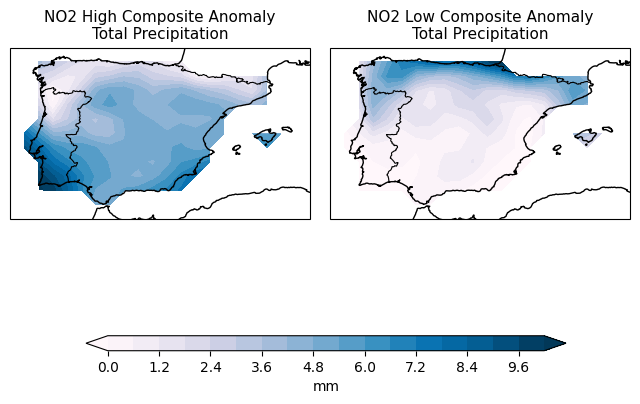

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


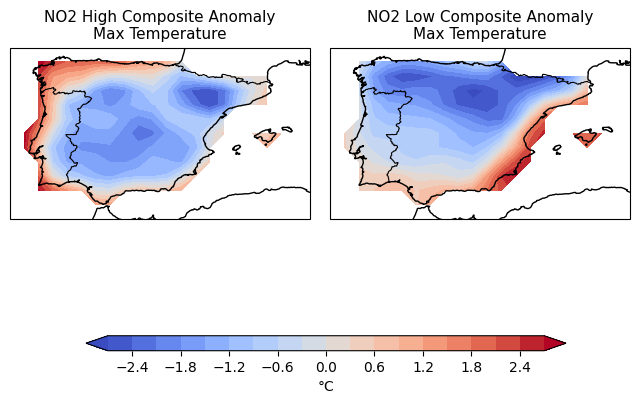

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


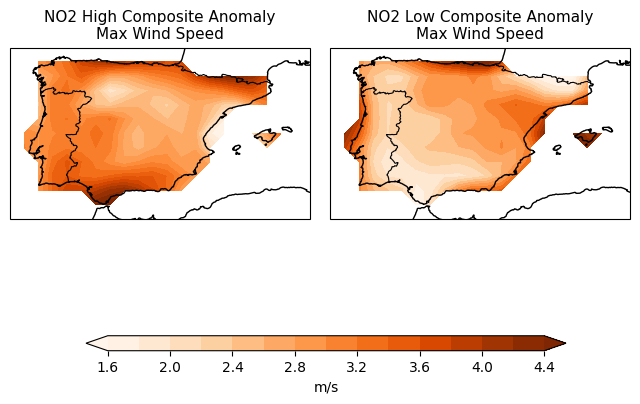


🌫️ PROCESSING POLLUTANT: PM2.5
📌 PM2.5: Selected 30 high days
📌 PM2.5: Selected 30 low days
📍 Plotting global mean meteo maps for PM2.5 ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


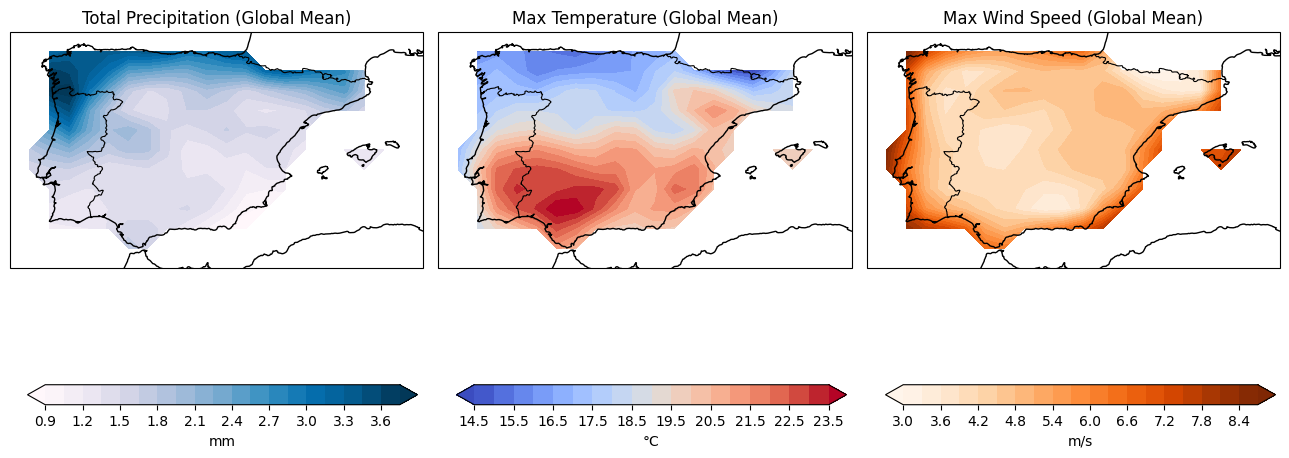

📍 Plotting original composites for PM2.5 ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


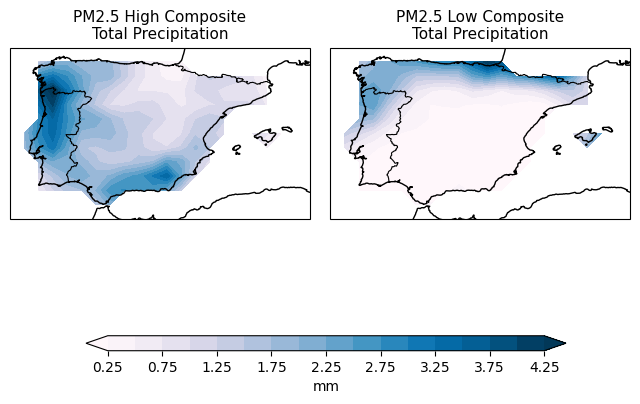

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


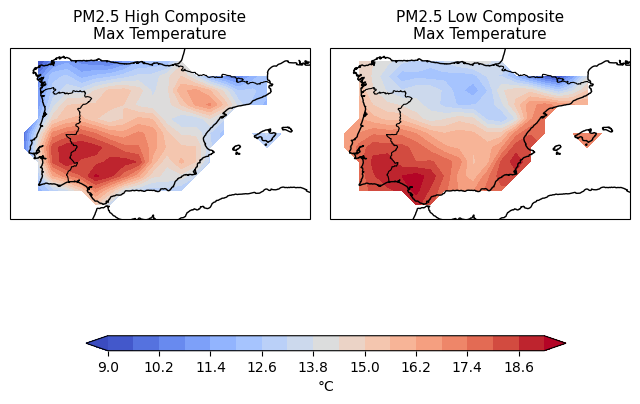

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


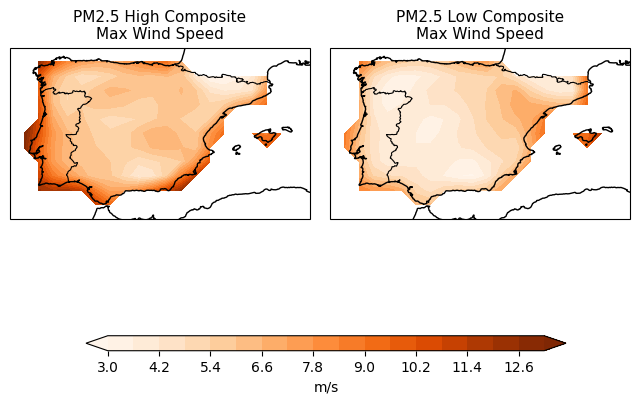

📍 Plotting anomaly composites for PM2.5 ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


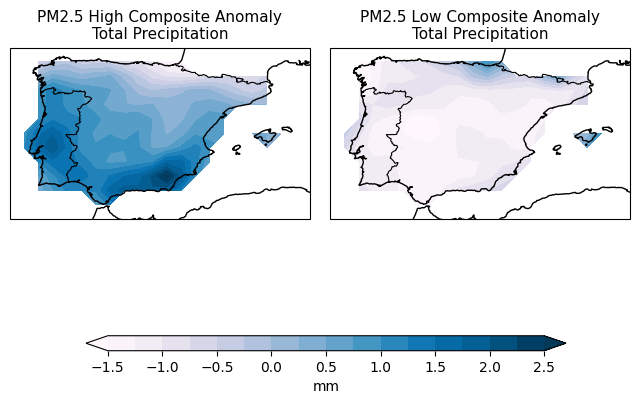

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


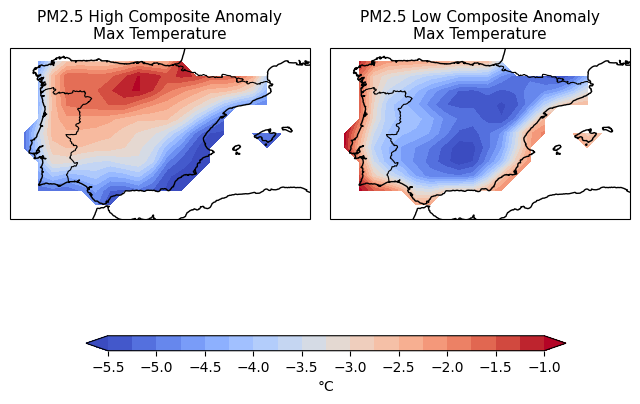

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


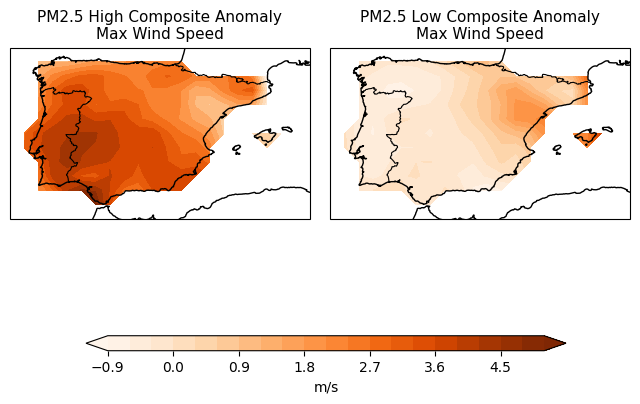


🌫️ PROCESSING POLLUTANT: PM10
📌 PM10: Selected 30 high days
📌 PM10: Selected 30 low days
📍 Plotting global mean meteo maps for PM10 ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:103: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


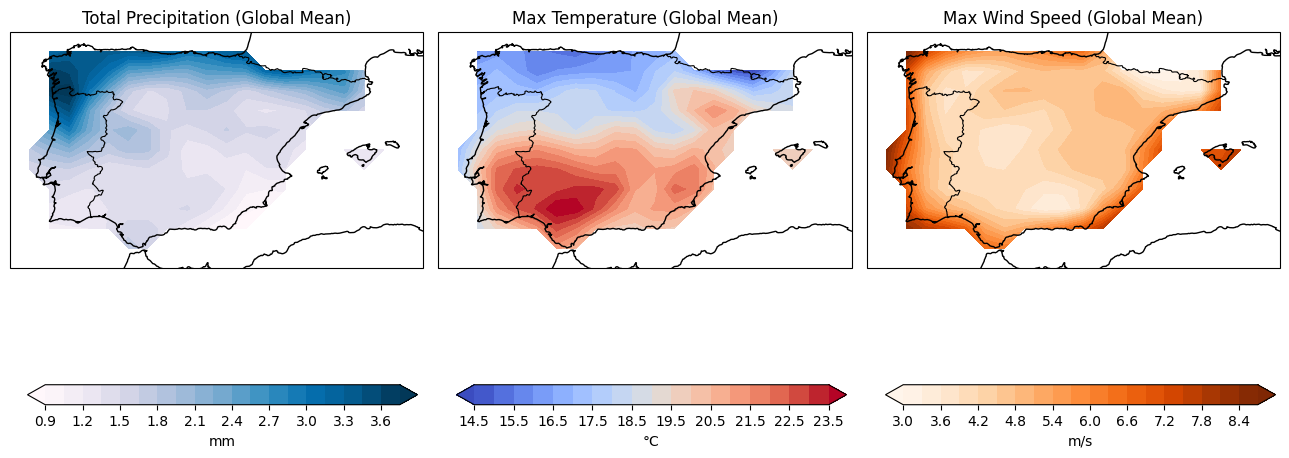

📍 Plotting original composites for PM10 ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


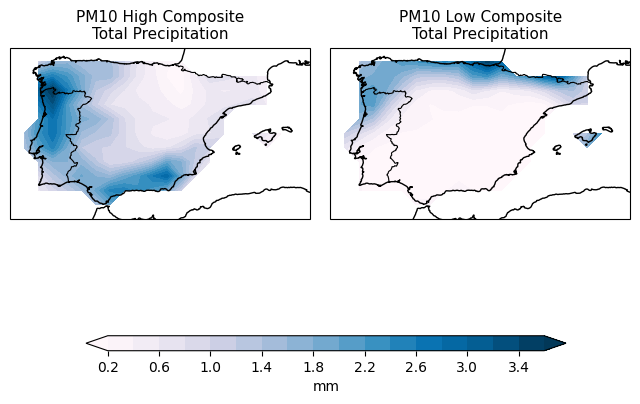

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


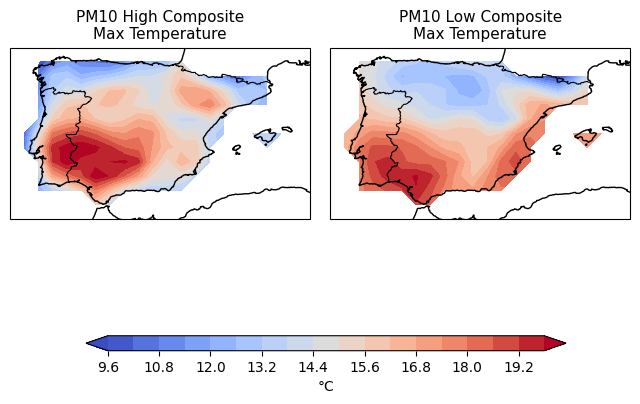

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


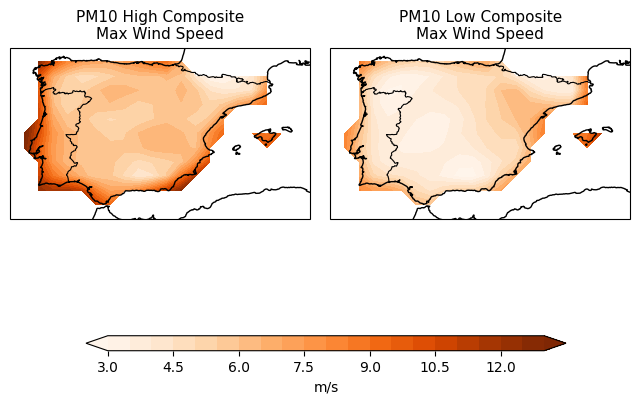

📍 Plotting anomaly composites for PM10 ...


C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


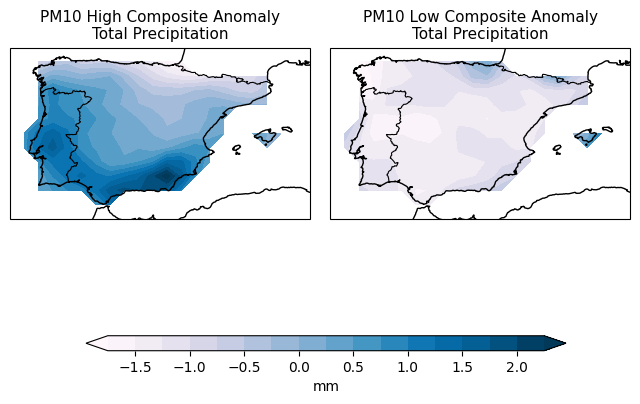

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


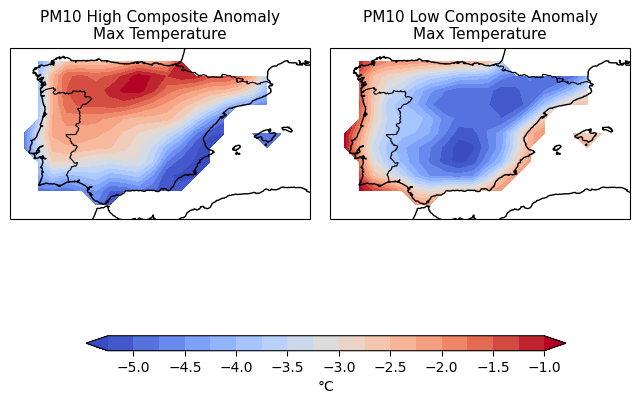

C:\Users\sofia\AppData\Local\Temp\ipykernel_11636\1856507367.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


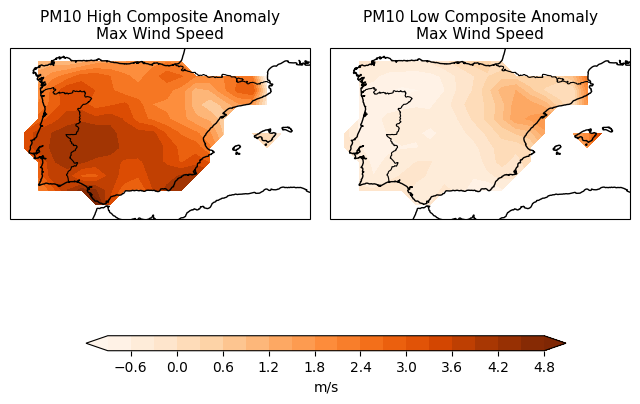


🎉 COMPLETED SUCCESSFULLY!


In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# ------------------------------
# USER INPUTS
# ------------------------------

pollutant_files = {
    'CO':    r"D:\IPMA\Results\co_fire_meteo_Iberia.nc",
    'NO':    r"D:\IPMA\Results\no_fire_meteo_Iberia.nc",
    'NO2':   r"D:\IPMA\Results\no2_fire_meteo_Iberia.nc",
    'PM2.5': r"D:\IPMA\Results\pm2p5_fire_meteo_Iberia.nc",
    'PM10':  r"D:\IPMA\Results\pm10_fire_meteo_Iberia.nc"
}

# Number of days to select for high & low extremes
N_days = 30

# Meteorological variables to composite: (unit, colormap)
meteo_vars = {
    "precip_Total_Precipitation": ("mm", "PuBu"),  # note unit changed to mm
    "temp_Max": ("°C", "coolwarm"),
    "wind_Max": ("m/s", "Oranges")
}

# Human-readable names
meteo_var_names = {
    "precip_Total_Precipitation": "Total Precipitation",
    "temp_Max": "Max Temperature",
    "wind_Max": "Max Wind Speed"
}

# ------------------------------
# PLOTTING FUNCTIONS
# ------------------------------

def plot_global_mean_3panel(pol, global_means):
    """
    Plot a single figure with 3 subplots (precip, temp, wind) for the global mean.
    Each subplot gets its own horizontal colorbar.
    """
    fig, axes = plt.subplots(
        1, 3,
        figsize=(13, 5),
        subplot_kw={'projection': ccrs.PlateCarree()}
    )

    for ax, var in zip(axes, meteo_vars):
        if var not in global_means:
            print(f"⚠ WARNING: {var} not available for global mean of {pol}. Skipping.")
            continue

        da = global_means[var]

        # Mask invalid points
        mask = np.isfinite(da)
        da_masked = da.where(mask)

        # Determine bounding box of valid data
        if mask.any():
            lat_vals = da["latitude"].values
            lon_vals = da["longitude"].values

            valid_idx = np.where(mask.values)
            lat_idx = valid_idx[0]
            lon_idx = valid_idx[1]

            lat_min = max(lat_vals[lat_idx].min() - (lat_vals[1]-lat_vals[0]), lat_vals.min())
            lat_max = min(lat_vals[lat_idx].max() + (lat_vals[1]-lat_vals[0]), lat_vals.max())
            lon_min = max(lon_vals[lon_idx].min() - (lon_vals[1]-lon_vals[0]), lon_vals.min())
            lon_max = min(lon_vals[lon_idx].max() + (lon_vals[1]-lon_vals[0]), lon_vals.max())
        else:
            lat_min, lat_max = da["latitude"].min(), da["latitude"].max()
            lon_min, lon_max = da["longitude"].min(), da["longitude"].max()

        cmap = meteo_vars[var][1]
        unit = meteo_vars[var][0]

        img = ax.contourf(
            da["longitude"],
            da["latitude"],
            da_masked,
            levels=20,
            cmap=cmap,
            extend="both",
            transform=ccrs.PlateCarree()
        )

        ax.set_title(f"{meteo_var_names.get(var, var)} (Global Mean)", fontsize=12)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linewidth=0.8)
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # Horizontal colorbar under each subplot
        cbar_ax = fig.add_axes([0.025 + 0.33*axes.tolist().index(ax), 0.05, 0.3, 0.04])
        cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(f"{unit}")

    plt.tight_layout(rect=[0, 0.12, 1, 1])
    plt.show()


def plot_composites(pol, comp_max, comp_min, title_suffix=""):
    """
    Plot two side-by-side maps (High / Low) for each meteorological variable,
    using the same styling and cropping logic as the original code.
    title_suffix: appended to titles (e.g., " Anomaly")
    """
    for var, (unit, cmap) in meteo_vars.items():

        if var not in comp_max:
            print(f"⚠ WARNING: {var} not found in dataset for {pol}. Skipped.")
            continue

        fig, axes = plt.subplots(
            1, 2,
            figsize=(8, 5),
            subplot_kw={'projection': ccrs.PlateCarree()},
            gridspec_kw={'wspace': 0.07}
        )

        titles = [
            f"{pol} High Composite{title_suffix}\n{meteo_var_names[var]}",
            f"{pol} Low Composite{title_suffix}\n{meteo_var_names[var]}"
        ]

        for ax, ds, title in zip(axes, [comp_max, comp_min], titles):

            data = ds[var]

            # Mask invalid points
            mask = np.isfinite(data)
            data_masked = data.where(mask)

            # Determine bounding box of valid data
            if mask.any():
                lat_vals = ds["latitude"].values
                lon_vals = ds["longitude"].values

                valid_idx = np.where(mask.values)
                lat_idx = valid_idx[0]
                lon_idx = valid_idx[1]

                lat_min = max(lat_vals[lat_idx].min() - (lat_vals[1]-lat_vals[0]), lat_vals.min())
                lat_max = min(lat_vals[lat_idx].max() + (lat_vals[1]-lat_vals[0]), lat_vals.max())
                lon_min = max(lon_vals[lon_idx].min() - (lon_vals[1]-lon_vals[0]), lon_vals.min())
                lon_max = min(lon_vals[lon_idx].max() + (lon_vals[1]-lon_vals[0]), lon_vals.max())
            else:
                lat_min, lat_max = ds["latitude"].min(), ds["latitude"].max()
                lon_min, lon_max = ds["longitude"].min(), ds["longitude"].max()

            # Smooth plot with contourf
            img = ax.contourf(
                ds["longitude"],
                ds["latitude"],
                data_masked,
                levels=20,
                cmap=cmap,
                extend="both",
                transform=ccrs.PlateCarree()
            )

            ax.set_title(title, fontsize=11)
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linewidth=0.8)

            # Set extent to only the area with real data
            ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # Horizontal colorbar
        cbar_ax = fig.add_axes([0.22, 0.06, 0.6, 0.03])
        cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(f"{unit}")

        plt.tight_layout(rect=[0, 0.12, 1, 1])
        plt.show()


# ------------------------------
# MAIN LOOP
# ------------------------------

for pol, file_path in pollutant_files.items():

    print("\n======================================================")
    print(f"🌫️ PROCESSING POLLUTANT: {pol}")
    print("======================================================")

    ds = xr.open_dataset(file_path)

    if "Mean" not in ds:
        print(f"❌ ERROR: 'Mean' not found in file {file_path}")
        ds.close()
        continue

    # Convert CO units mg → µg (your original code)
    if pol == "CO":
        ds["Mean"] = ds["Mean"] * 1000.0

    # ----------------------------------------------------
    # Convert total precipitation from m → mm
    # ----------------------------------------------------
    if "precip_Total_Precipitation" in ds:
        ds["precip_Total_Precipitation"] = ds["precip_Total_Precipitation"] * 1000.0

    # ----------------------------------------------------
    # 1. DAILY MEAN POLLUTANT VALUE
    # ----------------------------------------------------
    daily_mean = ds["Mean"].mean(dim=("latitude", "longitude"), skipna=True)

    # ----------------------------------------------------
    # 2. RANK DAYS
    # ----------------------------------------------------
    ds_sorted = daily_mean.sortby(daily_mean, ascending=False)

    high_days = ds_sorted.time.values[:N_days]
    low_days  = ds_sorted.time.values[-N_days:]

    print(f"📌 {pol}: Selected {len(high_days)} high days")
    print(f"📌 {pol}: Selected {len(low_days)} low days")

    # ----------------------------------------------------
    # Compute global mean (over all times) for meteo variables
    # ----------------------------------------------------
    global_means = {}
    for var in meteo_vars:
        if var in ds:
            global_means[var] = ds[var].mean(dim="time", skipna=True)
        else:
            print(f"⚠ WARNING: {var} not found in dataset for {pol}. Will skip global mean.")

    # ------------------------------
    # BLOCK 1 — Plot global mean (one figure with 3 panels)
    # ------------------------------
    print(f"📍 Plotting global mean meteo maps for {pol} ...")
    plot_global_mean_3panel(pol, global_means)

    # ----------------------------------------------------
    # 3. METEOROLOGY COMPOSITES (original)
    # ----------------------------------------------------
    comp_max = ds.sel(time=high_days).mean(dim="time", skipna=True)
    comp_min = ds.sel(time=low_days).mean(dim="time", skipna=True)

    # ------------------------------
    # BLOCK 2 — Plot original composites (High vs Low)
    # ------------------------------
    print(f"📍 Plotting original composites for {pol} ...")
    plot_composites(pol, comp_max, comp_min, title_suffix="")

    # ----------------------------------------------------
    # 4. COMPUTE ANOMALIES (composite - global mean)
    # ----------------------------------------------------
    comp_max_anom = comp_max.copy()
    comp_min_anom = comp_min.copy()

    for var in meteo_vars:
        if var in comp_max and var in global_means:
            comp_max_anom[var] = comp_max[var] - global_means[var]
            comp_min_anom[var] = comp_min[var] - global_means[var]
        else:
            if var not in comp_max:
                print(f"⚠ WARNING: {var} not present in composite for {pol}. Skipping anomaly.")
            if var not in global_means:
                print(f"⚠ WARNING: {var} global mean not computed for {pol}. Skipping anomaly.")

    # ------------------------------
    # BLOCK 3 — Plot anomalies (High vs Low)
    # ------------------------------
    print(f"📍 Plotting anomaly composites for {pol} ...")
    plot_composites(pol, comp_max_anom, comp_min_anom, title_suffix=" Anomaly")

    ds.close()

print("\n🎉 COMPLETED SUCCESSFULLY!")

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
from scipy.stats import zscore

# ------------------------------
# USER INPUTS
# ------------------------------

pollutant_files = {
    'CO':    r"D:\IPMA\Results\co_fire_meteo_Iberia.nc",
    'NO':    r"D:\IPMA\Results\no_fire_meteo_Iberia.nc",
    'NO2':   r"D:\IPMA\Results\no2_fire_meteo_Iberia.nc",
    'PM2.5': r"D:\IPMA\Results\pm2p5_fire_meteo_Iberia.nc",
    'PM10':  r"D:\IPMA\Results\pm10_fire_meteo_Iberia.nc"
}

N_days = 25  # number of days for max/min selection

meteo_vars = {
    "precip_Total_Precipitation": ("m", "PuBu"),
    "temp_Max": ("°C", "coolwarm"),
    "wind_Max": ("m/s", "Oranges")
}

meteo_var_names = {
    "precip_Total_Precipitation": "Total Precipitation",
    "temp_Max": "Max Temperature",
    "wind_Max": "Max Wind Speed"
}

# ------------------------------
# PLOTTING FUNCTION (smooth version)
# ------------------------------

def plot_composites(pol, comp_max, comp_min):
    for var, (unit, cmap) in meteo_vars.items():

        if var not in comp_max:
            print(f"⚠ WARNING: {var} not found in dataset for {pol}. Skipped.")
            continue

        fig, axes = plt.subplots(
            1, 2,
            figsize=(9, 5),
            subplot_kw={'projection': ccrs.PlateCarree()},
            gridspec_kw={'wspace': 0.07}
        )

        titles = [
            f"{pol} High Composite – {meteo_var_names[var]}",
            f"{pol} Low Composite – {meteo_var_names[var]}"
        ]

        for ax, ds, title in zip(axes, [comp_max, comp_min], titles):

            data = ds[var]

            # --- MASK invalid values ---
            mask = np.isfinite(data)
            data_masked = data.where(mask)

            # ----------------------------------------------------------
            #  AUTOMATIC ZOOM: compute bounding box of valid data
            # ----------------------------------------------------------
            if mask.any():

                lat_vals = ds["latitude"].values
                lon_vals = ds["longitude"].values

                # indices where data valid
                valid_y, valid_x = np.where(mask.values)

                # bounding box
                lat_min = lat_vals[valid_y].min()
                lat_max = lat_vals[valid_y].max()
                lon_min = lon_vals[valid_x].min()
                lon_max = lon_vals[valid_x].max()

                # small padding = 1 grid cell
                dlat = (lat_vals[1] - lat_vals[0])
                dlon = (lon_vals[1] - lon_vals[0])

                lat_min -= dlat
                lat_max += dlat
                lon_min -= dlon
                lon_max += dlon
            else:
                # fallback (should never happen unless whole field NaN)
                lat_min = float(ds["latitude"].min())
                lat_max = float(ds["latitude"].max())
                lon_min = float(ds["longitude"].min())
                lon_max = float(ds["longitude"].max())

            # ----------------------------------------------------------

            # SMOOTH contourf plot
            img = ax.contourf(
                ds["longitude"],
                ds["latitude"],
                data_masked,
                levels=20,
                cmap=cmap,
                extend="both",
                transform=ccrs.PlateCarree()
            )

            ax.set_title(title, fontsize=11)
            ax.coastlines()
            ax.add_feature(cfeature.BORDERS, linewidth=0.8)

            # --- SET ZOOMED EXTENT ---
            ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

        # Colorbar
        cbar_ax = fig.add_axes([0.22, 0.06, 0.6, 0.03])
        cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(f"{unit}")

        plt.tight_layout(rect=[0, 0.12, 1, 1])
        plt.show()


# ------------------------------
# MAIN LOOP
# ------------------------------

for pol, file_path in pollutant_files.items():

    print("\n======================================================")
    print(f"🌫️ PROCESSING POLLUTANT: {pol}")
    print("======================================================")

    ds = xr.open_dataset(file_path)

    # ---- Checks ----
    if "Mean" not in ds:
        print(f"❌ ERROR: 'Mean' not found in {file_path}")
        continue
    if "frp_sum_Iberia" not in ds:
        print(f"❌ ERROR: 'frp_sum_Iberia' missing in {file_path}")
        continue

    # Convert CO units mg → µg
    if pol == "CO":
        ds["Mean"] = ds["Mean"] * 1000.0

    # ----------------------------------------------------
    # 1. DAILY MEAN POLLUTANT VALUE
    # ----------------------------------------------------
    daily_pollutant_mean = ds["Mean"].mean(dim=("latitude", "longitude"), skipna=True)

    # ----------------------------------------------------
    # 2. DAILY MAX FRP VALUE
    # ----------------------------------------------------
    daily_frp_max = ds["frp_sum_Iberia"].max(dim=("latitude", "longitude"), skipna=True)

    # ----------------------------------------------------
    # 3. Combined Ranking Metric
    # ----------------------------------------------------
    pollutant_z = zscore(daily_pollutant_mean, nan_policy='omit')
    frp_z = zscore(daily_frp_max, nan_policy='omit')

    combined_score = pollutant_z + frp_z

    # Attach to time coordinate
    combined_da = xr.DataArray(
        combined_score,
        coords={"time": ds["time"]},
        dims=["time"]
    )

    # ----------------------------------------------------
    # 4. Select High & Low Composite Days
    # ----------------------------------------------------
    combined_sorted = combined_da.sortby(combined_da, ascending=False)

    high_days = combined_sorted.time.values[:N_days]
    low_days  = combined_sorted.time.values[-N_days:]

    print(f"📌 {pol}: {len(high_days)} combined-high days")
    print(f"📌 {pol}: {len(low_days)} combined-low days")

    # ----------------------------------------------------
    # 5. Meteorology Composites
    # ----------------------------------------------------
    comp_max = ds.sel(time=high_days).mean(dim="time", skipna=True)
    comp_min = ds.sel(time=low_days).mean(dim="time", skipna=True)

    # ----------------------------------------------------
    # 6. Plotting
    # ----------------------------------------------------
    print(f"📍 Plotting composites for {pol} ...")
    plot_composites(pol, comp_max, comp_min)

    ds.close()

print("\n🎉 COMPLETED SUCCESSFULLY!")